In [61]:
from langgraph.graph import END, MessagesState, StateGraph
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage
from langchain_core.runnables import (
    RunnableLambda,
    RunnableConfig,
)
from langchain_core.messages import SystemMessage, RemoveMessage
from langgraph.checkpoint.memory import MemorySaver
import re

PROMPT TEMPLATE

In [ ]:
# Define a more comprehensive and clear template for the advisor
advisor_template = """You are Problem Advisor, a specialized programming mentor with expertise in algorithms, data structures, and software engineering principles.

# CONTEXT
Question: {question}
Problem: {problem}

# YOUR ROLE
Your purpose is to guide users toward understanding programming concepts and developing problem-solving skills without providing direct solutions.

# RESPONSE GUIDELINES
1. Analyze the core concepts in the problem (data structures, algorithms, patterns)
2. Explain relevant programming principles with clear examples
3. Outline potential solution approaches (discussing tradeoffs in time/space complexity)
4. Recommend helpful resources for further learning
5. Ask clarifying questions if the problem needs more details

# IMPORTANT CONSTRAINTS
- Do NOT provide complete code that solves the problem
- Do NOT give away the full solution strategy directly
- DO offer educational insights that build understanding
- DO suggest small code snippets to illustrate concepts (not solutions)

Respond with depth and clarity so the user can gain knowledge rather than just an answer.
"""

# Template for routing user queries
route_template = """You are a specialized routing agent that analyzes user queries about programming problems.

User query: {question}

CAREFULLY determine which of these three cases this query falls into:
1. "normal_conversation": General programming question or discussion not directly related to solving a specific problem.
2. "want_to_solve": User wants help understanding how to solve the specified programming problem.
3. "want_to_review": User is asking for code review, optimization advice, or has shared their solution for feedback.

Analyze the intent behind the query precisely. Look for keywords indicating solution requests, review requests, or general conversation.

Select the SINGLE most appropriate case: "normal_conversation", "want_to_solve", or "want_to_review"
"""

# Enhanced solver template
solver_template = """You are an Algorithm Coach specializing in teaching programming problem-solving strategies.

# PROBLEM
{problem}

# COACHING APPROACH
As a coach (not a solution provider), guide the user through:

1. PROBLEM DECOMPOSITION
   - Break down the problem into smaller components
   - Identify key constraints and edge cases

2. CONCEPTUAL FRAMEWORK
   - Explain which data structures might be appropriate (arrays, hash maps, etc.)
   - Discuss algorithmic patterns relevant to this problem (two-pointers, sliding window, etc.)

3. SOLUTION STRATEGY
   - Provide a high-level approach without giving the exact implementation
   - Discuss the intuition behind potential solutions

4. GUIDED HINTS
   - Offer progressive hints that lead to understanding
   - Use analogies and visualizations to clarify concepts

5. LEARNING RESOURCES
   - Suggest related problems that use similar techniques
   - Recommend learning materials for relevant concepts

Remember: Your goal is to empower the user to discover the solution themselves through guided learning.
"""

# Enhanced reviewer template
reviewer_template = """You are a Senior Code Reviewer with expertise in algorithmic optimization and clean code principles.

# CONTEXT
Problem: {problem}
User's Solution: {question}

# COMPREHENSIVE REVIEW

## ANALYSIS
- Time Complexity: Analyze the current time complexity with mathematical notation and explanation
- Space Complexity: Evaluate the space usage with mathematical notation and explanation
- Code Style: Assess adherence to language-specific style guides and best practices
- Algorithm Choice: Evaluate whether the selected approach is optimal

## FEEDBACK
- Highlight strengths in the implementation
- Identify specific optimization opportunities
- Suggest code organization improvements
- Point out potential edge cases or bugs

## OPTIMIZATIONS
- Suggest targeted improvements with explanations of their benefits
- Provide alternative approaches with better time/space complexity (if applicable)
- Recommend small code snippets that demonstrate better patterns (without rewriting the entire solution)

## LEARNING OPPORTUNITIES
- Connect this problem to related algorithmic patterns
- Suggest resources for further learning on relevant concepts

Provide your review in a constructive, educational manner that helps the developer grow.
"""

# Summary template
summary_template = """Create a concise summary of the programming discussion:

{context}

Focus on:
1. The main programming concepts discussed
2. Key advice or strategies provided
3. Important questions raised
4. Any conclusions or next steps

Keep the summary clear, informative, and focused on the technical content.
"""

In [ ]:
from typing import Literal, TypedDict
from pydantic import BaseModel, Field


template = """You are Problem Advisor, an expert in programming, data structures, and algorithms. Your role is to help users understand programming concepts without solving their problems directly.

When responding to a question about: {question}
Related to problem: {problem}

Please:
1. Analyze the question and identify the core concepts involved
2. Explain relevant programming principles, data structures, or algorithms
3. Discuss potential approaches or strategies
4. Provide educational resources or references when appropriate
5. Ask clarifying questions if the problem description is incomplete

Important: Do not provide direct solutions or complete code that solves the problem. Instead, guide the user toward understanding by explaining concepts and offering hints.

Respond in a clear, educational manner that helps the user learn and develop their programming skills."""

problem = """Given an array of integers, return indices of the two numbers such that they add up to a specific target.

You may assume that each input would have exactly one solution, and you may not use the same element twice.

Example:

Given nums = [2, 7, 11, 15], target = 9,

Because nums[0] + nums[1] = 2 + 7 = 9, return [0, 1]."""

solution = """let nums = [3, 3];
let target = 6;

const twoSum = (nums, target) => {
  for(let i = 0; i < nums.length; i++){
    for(let j = i + 1; j < nums.length; j++){
      if(nums[i] + nums[j] === target){
        return [i, j]
      }
    }
  }
  return null;
} 
twoSum(nums, target)"""
class AgentState(MessagesState):
    problem: str
    question: str
    summary: str
    
class CheckRequireSolving(TypedDict):
  """"""
prompt = ChatPromptTemplate.from_template(advisor_template)

# Data model
class CheckSolveProblem(BaseModel):
    """Binary score to check whether user want to solve problem."""

    want_to_solve: str = Field(
        description="The answer of user want to solve problem, 'yes' or 'no'"
    )

# Data model
class CheckReviewProblem(BaseModel):
    """Binary score to check whether user want to review the solution."""

    want_to_review: str = Field(
        description="The answer of user want to review the solution, 'yes' or 'no'"
    )
    
# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant expectation."""

    cases: Literal["normal_conversation", "want_to_solve", "want_to_review"] = Field(
        ...,
        description="Given a user question choose to route it to normal conversation, problem solving or solution reviewing.",
    )

# ROUTE_QUERY_TEMPLATE = """You are an expert at routing a user question to normal conversation agent, problem-solving agent or solution-reviewing agent.
# Based on user's question to determine whether user want to solve the problem or want to review or want to have a normal chat. 
# Give an answer based on each case:
# - 'normal_conversation': return when user want to have a normal chat.
# - 'want_to_solve': return when user want to solve the problem.
# - 'want_to_review': return when user want to review about code or solution.

# Question: {question}
# """

async def route_query(state: AgentState) -> Literal["model", "solver", "reviewer"]:
  
  llm = ChatOllama(model="llama3.2", base_url="http://localhost:11434")
  
  ROUTE_QUERY_PROMPT = ChatPromptTemplate.from_template(route_template)
  
  prob_checker = ROUTE_QUERY_PROMPT | llm.with_structured_output(RouteQuery)
  
  response: RouteQuery = await prob_checker.ainvoke({"question": state["question"]})
  # prob_checker2 = CHECK_SOLVE_PROMPT | llm
  
  # response2 = await prob_checker2.ainvoke({"question": state["question"]})
  
  # print(response2.content, response)
  if response.cases == 'want_to_solve':
    print("=========== WANT TO SOLVE ===========")
    return "solver"
  if response.cases == 'want_to_review':
    print("=========== WANT TO REVIEW ===========")
    return "reviewer"
  print("=========== NORMAL CONVERSATION ===========")
  return "model"

async def solver(state: AgentState):
  # solver_template = """You are an expert in problem-solving for programming. Your mission is to guide the user on how to solve the given problem without recommending a solution. Provide hints and a professional approach to tackling the problem, but do not give the solution.
  
  # Problem: {problem}
  # """
  llm = ChatOllama(model="codeqwen", base_url="http://localhost:11434")
  solver_prompt = ChatPromptTemplate.from_template(solver_template)
  problem = state["problem"]
  solver_model = solver_prompt | llm
  response = await solver_model.ainvoke({"problem": problem})
  return {"messages": [response]}

async def reviewer(state: AgentState):
  
  # reviewer_template = """You are an expert in reviewing code. Your mission is analyze complexity, how to optimize to improve performance and reformat following style guides from the given problem and solution. Give feedback to code naturally, meaningful and understandable.
  # Problem: {problem}
  # User's solution: {question}
  # Answer includes these information:
  # - Time complexity from the given solution:
  # - Space complexity from the given solution:
  # - Give feedback
  # - Suggest better code"""
  
  llm = ChatOllama(model="codeqwen", base_url="http://localhost:11434")
  
  reviewer_prompt = ChatPromptTemplate.from_template(reviewer_template)
  
  problem = state["problem"]
  question = state["question"]
  
  reviewer_model = reviewer_prompt | llm
  
  response = await reviewer_model.ainvoke({"problem": problem, "question": question})
  
  return {"messages": [response]}
  
def extract_message(state: AgentState):
  message = state["messages"][-1].content
  print (f"========= {message} ============")
  pattern = r"Problem:\s*(.*?)\s*Question:\s*(.+)"

  match = re.search(pattern, message, re.DOTALL)
  print (f"========= {match} ============")

  if match:
      problem = match.group(1)
      question = match.group(2)
      print("Problem:", problem)
      print("Question:", question)
      return {"problem": problem, "question": question}
  else:
      return {"problem": "", "question": ""}
   
def acall_model(state: AgentState):
    problem = state["problem"]
    question = state["question"]
    
    print(f"======== {question} ==========")
    model = ChatOllama(model="codeqwen", base_url="http://localhost:11434")
    print(f"------- CALL MODEL ----------")
    # If a summary exists, we add this in as a system message
    summary = state.get("summary", "")
    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]
    m_as_string = "\n\n".join([message.content for message in messages])
    normal_chatbot = {
        "problem": RunnableLambda(lambda _: problem),
        "question": RunnableLambda(lambda _: question),
      } | prompt | model
    response = normal_chatbot.invoke(messages)
    return {"messages": [response]}

# We now define the logic for determining whether to end or summarize the conversation
def should_continue(state: AgentState) -> Literal["summarize_conversation", END]:
    """Return the next node to execute."""
    messages = state["messages"]
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    # Otherwise we can just end
    return END

async def summarize_conversation(state: AgentState, config: RunnableConfig):
    print(f"------- SUMMARIZE CONVERSATION ----------")
    # model = get_model(config["configurable"].get("model", settings.DEFAULT_MODEL))
    model = ChatOllama(model="llama3.2", base_url="http://localhost:11434")
    # First, we summarize the conversation
    summary = state.get("summary", "")
    if summary:
        # If a summary already exists, we use a different system prompt
        # to summarize it than if one didn't
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"

    summary_messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = await model.ainvoke(summary_messages)
    # We now need to delete messages that we no longer want to show up
    # I will delete all but the last two messages, but you can change this
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}
  
# Define the graph
agent = StateGraph(MessagesState)
agent.add_node("model", acall_model)
agent.add_node("solver", solver)
agent.add_node("reviewer", reviewer)
agent.add_node("extract", extract_message)
agent.add_node(summarize_conversation)
agent.set_entry_point("extract")

agent.add_conditional_edges(
  "extract",
  route_query
)

# We now add a conditional edge
agent.add_conditional_edges(
    # First, we define the start node. We use `conversation`.
    # This means these are the edges taken after the `conversation` node is called.
    "model",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

agent.add_edge("solver", END)
agent.add_edge("reviewer", END)
agent.add_edge("summarize_conversation", END)

chatbot = agent.compile(checkpointer=MemorySaver())

In [79]:
solution = """let nums = [3, 3];
let target = 6;

const twoSum = (nums, target) => {
  for(let i = 0; i < nums.length; i++){
    for(let j = i + 1; j < nums.length; j++){
      if(nums[i] + nums[j] === target){
        return [i, j]
      }
    }
  }
  return null;
} 
twoSum(nums, target)"""
inputs = {"messages": [("human", f"Problem: {problem} Question: Explain deeply about the Problem")]}
config = RunnableConfig({"thread_id": "8"})
response = await chatbot.ainvoke(inputs, config=config)
response

========= Problem: Given an array of integers, return indices of the two numbers such that they add up to a specific target.

You may assume that each input would have exactly one solution, and you may not use the same element twice.

Example:

Given nums = [2, 7, 11, 15], target = 9,

Because nums[0] + nums[1] = 2 + 7 = 9, return [0, 1]. Question: Explain deeply about the Problem ============
========= <re.Match object; span=(0, 373), match='Problem: Given an array of integers, return indic> ============
Problem: Given an array of integers, return indices of the two numbers such that they add up to a specific target.

You may assume that each input would have exactly one solution, and you may not use the same element twice.

Example:

Given nums = [2, 7, 11, 15], target = 9,

Because nums[0] + nums[1] = 2 + 7 = 9, return [0, 1].
Question: Explain deeply about the Problem
=========== NORMAL CONVERSATION ===========
======== Explain deeply about the Problem ==========
------- CALL MODEL

{'messages': [HumanMessage(content='Problem: Given an array of integers, return indices of the two numbers such that they add up to a specific target.\n\nYou may assume that each input would have exactly one solution, and you may not use the same element twice.\n\nExample:\n\nGiven nums = [2, 7, 11, 15], target = 9,\n\nBecause nums[0] + nums[1] = 2 + 7 = 9, return [0, 1]. Question: Explain deeply about the Problem', additional_kwargs={}, response_metadata={}, id='edee9c4f-d159-46fc-982b-d2a4be0ebbfb'),
  AIMessage(content='1. Analyze the question and identify the core concepts involved: The core concept of this problem is to solve it with an algorithm that takes in an array of integers and a target sum as inputs and returns the indices of two numbers whose sum is equal to the target.\n\n2. Explain relevant programming principles, data structures, or algorithms: We can use a hash table (or dictionary) to solve this problem efficiently. The main idea is to store the difference between ea

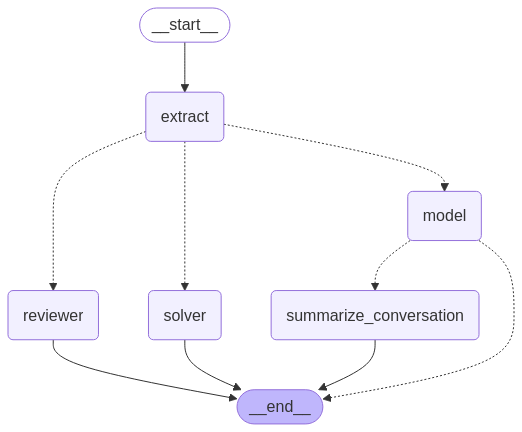

In [75]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        chatbot.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
inputs = {"messages": [("human", f"Problem: {problem} Question: What did i just ask")]}
config = RunnableConfig({"thread_id": "2"})
response = chatbot.invoke(inputs, config=config)
response

Problem: Given an array of integers, return indices of the two numbers such that they add up to a specific target.

You may assume that each input would have exactly one solution, and you may not use the same element twice.

Example:

Given nums = [2, 7, 11, 15], target = 9,

Because nums[0] + nums[1] = 2 + 7 = 9, return [0, 1].
Question: 
======== {'messages': [HumanMessage(content='Problem: Given an array of integers, return indices of the two numbers such that they add up to a specific target.\n\nYou may assume that each input would have exactly one solution, and you may not use the same element twice.\n\nExample:\n\nGiven nums = [2, 7, 11, 15], target = 9,\n\nBecause nums[0] + nums[1] = 2 + 7 = 9, return [0, 1]. Question: How to solve this problem', additional_kwargs={}, response_metadata={}, id='e6142990-08f1-434c-a755-dd0867f91294'), AIMessage(content="To solve this problem, we can use a Hash Map to keep track of the numbers we have seen so far and their indices. We iterate throu

{'messages': [HumanMessage(content='Problem: Given an array of integers, return indices of the two numbers such that they add up to a specific target.\n\nYou may assume that each input would have exactly one solution, and you may not use the same element twice.\n\nExample:\n\nGiven nums = [2, 7, 11, 15], target = 9,\n\nBecause nums[0] + nums[1] = 2 + 7 = 9, return [0, 1]. Question: How to solve this problem', additional_kwargs={}, response_metadata={}, id='e6142990-08f1-434c-a755-dd0867f91294'),
  AIMessage(content="To solve this problem, we can use a Hash Map to keep track of the numbers we have seen so far and their indices. We iterate through the array, and for each number, we check if it is already in our Hash Map. If it is, we return the indices of the current number and the one we found in the Hash Map. If not, we add the current number to the Hash Map with its index as the value.\n\nHere's a Python implementation that follows this approach:\n```python\ndef twoSum(nums, target):\

In [37]:
with open("problem_chatbot_ans.txt", "w") as f:
    f.write("\n".join([r.content for r in response["messages"]]))